
[Data] Đang tải dataset từ HuggingFace...
[Preprocessing] Đang xử lý cột 'comment_text' bằng Fast Regex...
 -> Đã loại bỏ 2502 dòng rỗng.
[Preprocessing] Đang xử lý cột 'comment_text' bằng Fast Regex...
 -> Đã loại bỏ 0 dòng rỗng.
[Data] Chia tập Train/Val (Stratified)...
[Data] Downsampling tập Train...
   -> Stats: Toxic=51886 | Normal=50000 (Kept)

[Feature] Đang vector hóa văn bản (TF-IDF C-Optimized)...
 -> Shape Train: (101886, 100000)

RUNNING MODEL: LinearSVC_Calibrated
 -> [Analysis] Đang vẽ Learning Curve (sẽ mất một lúc)...


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1173: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(f, fprime, xk, pk, gfk,


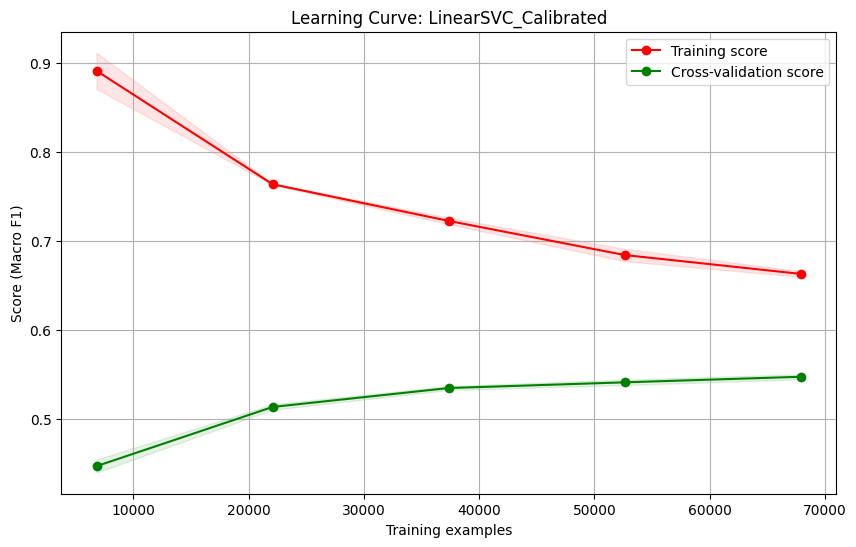

 -> Đã hiển thị Learning Curve.
 -> Fitting model (Final)...
 -> Tuning thresholds...
 -> Best Val F1: 0.4260
 -> Predicting Test set...

[RESULT] AUC: 0.8426 | F1 Default: 0.5734 | F1 Tuned: 0.5691

RUNNING MODEL: SGD_LogLoss
 -> [Analysis] Đang vẽ Learning Curve (sẽ mất một lúc)...


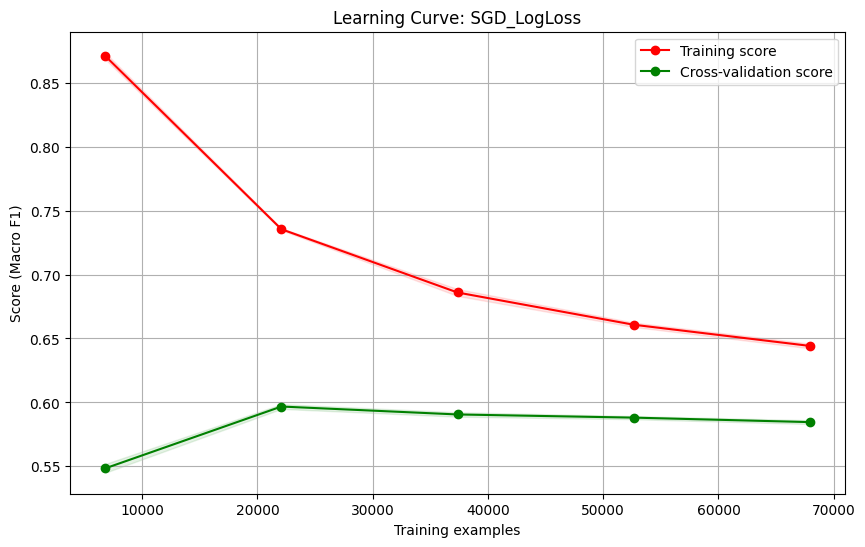

 -> Đã hiển thị Learning Curve.
 -> Fitting model (Final)...
 -> Tuning thresholds...
 -> Best Val F1: 0.4059
 -> Predicting Test set...

[RESULT] AUC: 0.8307 | F1 Default: 0.6454 | F1 Tuned: 0.5323

RUNNING MODEL: ComplementNB
 -> [Analysis] Đang vẽ Learning Curve (sẽ mất một lúc)...


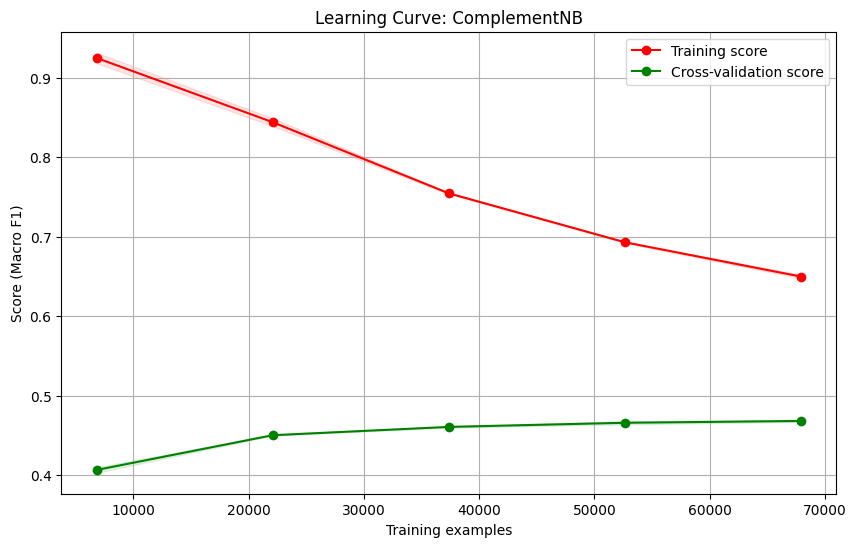

 -> Đã hiển thị Learning Curve.
 -> Fitting model (Final)...
 -> Tuning thresholds...
 -> Best Val F1: 0.3639
 -> Predicting Test set...

[RESULT] AUC: 0.8064 | F1 Default: 0.6020 | F1 Tuned: 0.5405

================ FINAL LEADERBOARD ================
               Model      AUC  F1_Default  F1_Tuned
LinearSVC_Calibrated 0.842554    0.573383  0.569059
        ComplementNB 0.806425    0.601971  0.540547
         SGD_LogLoss 0.830717    0.645409  0.532304


In [2]:
import os
import re
import html
import random
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from typing import Tuple, List, Dict
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

# ==========================================
# CONFIGURATION
# ==========================================
SEED = 42
TEXT_COL = "comment_text"
LABEL_COLS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

THR_BIN = 0.8          
KEEP_NORMAL = 100_000   
VAL_RATIO = 0.1        
MAX_FEATURES = 100_000 

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

# ==========================================
# ULTRA-FAST PREPROCESSING (Regex Only)
# ==========================================
_URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
_IP_USER_PATTERN = re.compile(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}|@\w+")
_CLEAN_PATTERN = re.compile(r"[^A-Za-z0-9\s!.,?']") 
_MULTI_SPACE = re.compile(r"\s+")

def fast_clean_text(text: str) -> str:
    if text is None or not isinstance(text, str):
        return ""
    
    text = html.unescape(text)
    text = text.lower()
    text = _URL_PATTERN.sub(" ", text)
    text = _IP_USER_PATTERN.sub(" ", text)
    text = _CLEAN_PATTERN.sub(" ", text)
    text = _MULTI_SPACE.sub(" ", text).strip()
    
    return text

def apply_fast_preprocessing(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    df = df.copy()
    proc_col = col_name + "_proc"
    
    df[proc_col] = df[col_name].fillna("").astype(str).map(fast_clean_text)
    
    initial_len = len(df)
    df = df[df[proc_col] != ""].reset_index(drop=True)
    
    return df, proc_col

# ==========================================
# DATA PIPELINE
# ==========================================
def binarize_labels(df: pd.DataFrame, cols: List[str], thr=0.5) -> pd.DataFrame:
    df = df.copy()
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        df[col] = (df[col] >= thr).astype("int64")
    return df

def downsample_negatives(df: pd.DataFrame, label_cols: List[str], keep_n: int) -> pd.DataFrame:
    df = df.copy()
    mask_neg = (df[label_cols].sum(axis=1) == 0)
    
    df_pos = df[~mask_neg]
    df_neg = df[mask_neg]
    
    if len(df_neg) > keep_n:
        df_neg = df_neg.sample(n=keep_n, random_state=SEED)
    
    print(f"   -> Stats: Toxic={len(df_pos)} | Normal={len(df_neg)} (Kept)")
    
    return pd.concat([df_pos, df_neg], axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)

def load_prepare_data():
    ds = load_dataset("nqdhocai/toxic-comment-detection")
    
    train_full = ds["train"].to_pandas()
    test_df = ds["test"].to_pandas()
    
    train_full = binarize_labels(train_full, LABEL_COLS, thr=THR_BIN)
    test_df = binarize_labels(test_df, LABEL_COLS, thr=THR_BIN)
    
    train_full, proc_col = apply_fast_preprocessing(train_full, TEXT_COL)
    test_df, _ = apply_fast_preprocessing(test_df, TEXT_COL)
    
    stratify_key = train_full[LABEL_COLS].sum(axis=1)
    train_df, val_df = train_test_split(
        train_full, test_size=VAL_RATIO, stratify=stratify_key, random_state=SEED
    )
    
    train_df = downsample_negatives(train_df, LABEL_COLS, keep_n=KEEP_NORMAL)
    
    return {
        "train": (train_df[proc_col].values, train_df[LABEL_COLS].values),
        "val":   (val_df[proc_col].values, val_df[LABEL_COLS].values),
        "test":  (test_df[proc_col].values, test_df[LABEL_COLS].values, test_df[TEXT_COL].values) # Giữ raw text cho test
    }

# ==========================================
# FEATURE ENGINEERING 
# ==========================================
def build_features(data_pack):
    X_train, _ = data_pack["train"]
    X_val, _   = data_pack["val"]
    X_test, _, _ = data_pack["test"]
    
    tfidf = TfidfVectorizer(
        stop_words='english',      
        token_pattern=r'\b\w\w+\b',
        ngram_range=(1, 2),      
        min_df=3, 
        max_df=0.9,
        sublinear_tf=True,
        max_features=MAX_FEATURES,
        strip_accents='unicode',
        dtype=np.float32            
    )
    
    Xtr_vec = tfidf.fit_transform(X_train)
    Xva_vec = tfidf.transform(X_val)
    Xte_vec = tfidf.transform(X_test)
    
    return tfidf, Xtr_vec, Xva_vec, Xte_vec

# ==========================================
# METRICS & THRESHOLD TUNING
# ==========================================
def tune_thresholds(y_true, y_prob, labels):
    best_thrs = {}
    f1_scores = []
    
    grid = np.linspace(0.1, 0.9, 81)
    
    for i, label in enumerate(labels):
        yt = y_true[:, i]
        yp = y_prob[:, i]
        
        best_f1 = -1
        best_t = 0.5
        
        for t in grid:
            pred = (yp >= t).astype(int)
            p, r, f, _ = precision_recall_fscore_support(yt, pred, average='binary', zero_division=0)
            if f > best_f1:
                best_f1 = f
                best_t = t
        
        best_thrs[label] = best_t
        f1_scores.append(best_f1)
        
    return best_thrs, np.mean(f1_scores)

def apply_thresholds(y_prob, thrs_map, labels):
    y_pred = np.zeros_like(y_prob, dtype=int)
    for i, lbl in enumerate(labels):
        t = thrs_map.get(lbl, 0.5)
        y_pred[:, i] = (y_prob[:, i] >= t).astype(int)
    return y_pred


import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator, 
    title, 
    X, 
    y, 
    ylim=None, 
    cv=3,
    n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5)
):

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve: {title}")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (Macro F1)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1_macro"
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# ==========================================
# TRAINING & EVALUATION ENGINE
# ==========================================
def train_eval_pipeline(model_name, model, data_pack, features, plot_lc=True):
    tfidf, Xtr, Xva, Xte = features
    ytr = data_pack["train"][1]
    yva = data_pack["val"][1]
    yte = data_pack["test"][1]
    raw_test_text = data_pack["test"][2]
        
    if plot_lc:
        try:
            plot_learning_curve(model, model_name, Xtr, ytr, cv=3)
        except Exception as e:
            print(f"Lỗi khi vẽ Learning Curve: {e}")

    model.fit(Xtr, ytr)
    if hasattr(model, "predict_proba"):
        val_probs = model.predict_proba(Xva)
        if isinstance(val_probs, list):
            val_probs = np.column_stack([p[:, 1] for p in val_probs])
    else:
        val_probs = model.decision_function(Xva)
    
    tuned_thrs, val_f1 = tune_thresholds(yva, val_probs, LABEL_COLS)
    print(f"Best Val F1: {val_f1:.4f}")
    
    if hasattr(model, "predict_proba"):
        test_probs = model.predict_proba(Xte)
        if isinstance(test_probs, list):
            test_probs = np.column_stack([p[:, 1] for p in test_probs])
    else:
        test_probs = model.decision_function(Xte)

    auc = roc_auc_score(yte, test_probs, average="macro")
    
    pred_def = (test_probs >= 0.5).astype(int)
    f1_def = precision_recall_fscore_support(yte, pred_def, average='macro', zero_division=0)[2]
    
    pred_tuned = apply_thresholds(test_probs, tuned_thrs, LABEL_COLS)
    f1_tuned = precision_recall_fscore_support(yte, pred_tuned, average='macro', zero_division=0)[2]
    
    print(f"\n[RESULT] AUC: {auc:.4f} | F1 Default: {f1_def:.4f} | F1 Tuned: {f1_tuned:.4f}")
    
    return {
        "Model": model_name,
        "AUC": auc,
        "F1_Default": f1_def,
        "F1_Tuned": f1_tuned
    }


data = load_prepare_data()

feats = build_features(data)

models = {
    "LinearSVC_Calibrated": OneVsRestClassifier(
        CalibratedClassifierCV(
            LinearSVC(C=0.1, class_weight="balanced", random_state=SEED, max_iter=2000),
            method='sigmoid', cv=3
        ), n_jobs=-1
    ),
    
    "SGD_LogLoss": OneVsRestClassifier(
        SGDClassifier(loss="log_loss", alpha=1e-4, max_iter=1000, 
                      class_weight="balanced", random_state=SEED, early_stopping=True),
        n_jobs=-1
    ),
    
    "ComplementNB": OneVsRestClassifier(
        ComplementNB(alpha=0.1),
        n_jobs=-1
    )
}

results = []
for name, clf in models.items():
    res = train_eval_pipeline(name, clf, data, feats)
    results.append(res)
    
final_df = pd.DataFrame(results).sort_values("F1_Tuned", ascending=False)
final_df.to_string(index=False)